# EECE 7398: Verifiable Machine Learning -- Fall 2025
# Exercise #1: Adversarial Examples & Decision Boundaries

**Submission Instructions:** Please upload a .ipynb file (including your code, plots, and written answers) to Gradescope.

This file can be updated unlimited times until the submission deadline.

## Problem 1: Train & Attack an MNIST Classifier

## 1a) Train an MNIST Classifier
**Deliverables**:
- Plot your train and validation loss curves as a function of epoch
- From a test set, provide some examples where your classifier predicted correctly & incorrectly (if applicable)

### **Setup**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import sympy, sys, pkgutil
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# Global parameters, functions
MEAN, STD = 0.1307, 0.3081 # MNIST mean and std

def denormalize(x):
    return x * STD + MEAN
def renormalize(x):
    return (x - MEAN) / STD

In [3]:
# plot Accuracy function
def plot_accuracy(Pertubations, Accurs, xlabel, Title, curve_color):
  plt.figure()
  plt.plot(Pertubations, Accurs, marker='o', color=curve_color, markerfacecolor='y') # color = red/blue/green/orange
  plt.xlabel(xlabel)
  plt.ylabel('Accuracy')
  plt.title(Title)
  plt.show()


In [4]:
# get train/ test dataset from MINST
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((MEAN, ), (STD, ))]) # mean 0.13, standard deviation 0.31
train_set = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)
test_set = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True)

gen = torch.Generator().manual_seed(40)  # easier debug
train_dataset, val_dataset = torch.utils.data.random_split(train_set, [0.8, 0.2], generator=gen)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size = 128, shuffle=True)

### NN-model

In [5]:
class NeuralNetwork(nn.Module):
  # input layer(input 28*28 features) ((28*28=784
  # -> hidden Layer1(# of neurons)
  # -> output(10 digit)
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(784, 128)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
      x = self.flatten(x)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      return x

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Training

Epoch 1/10 | train 0.3282 | val 0.2020
Epoch 2/10 | train 0.1482 | val 0.1495
Epoch 3/10 | train 0.1033 | val 0.1137
Epoch 4/10 | train 0.0786 | val 0.1014
Epoch 5/10 | train 0.0609 | val 0.0968
Epoch 6/10 | train 0.0500 | val 0.0928
Epoch 7/10 | train 0.0414 | val 0.0905
Epoch 8/10 | train 0.0340 | val 0.0850
Epoch 9/10 | train 0.0268 | val 0.0831
Epoch 10/10 | train 0.0230 | val 0.0854


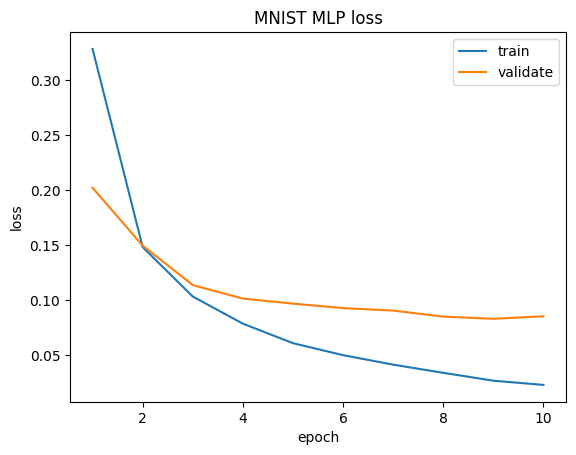

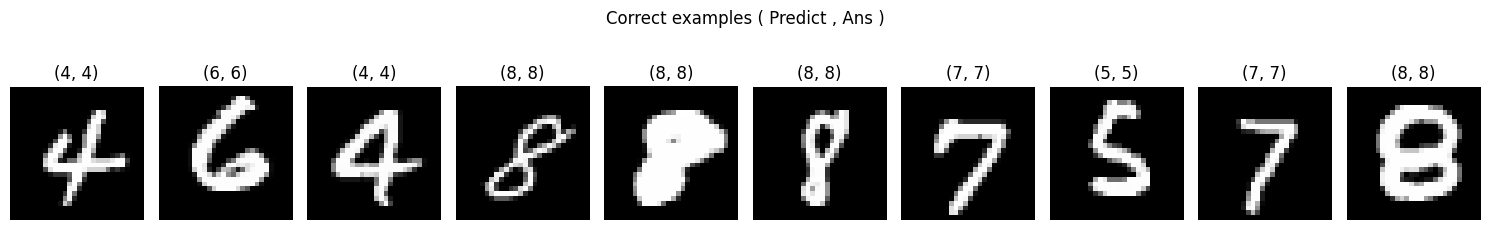

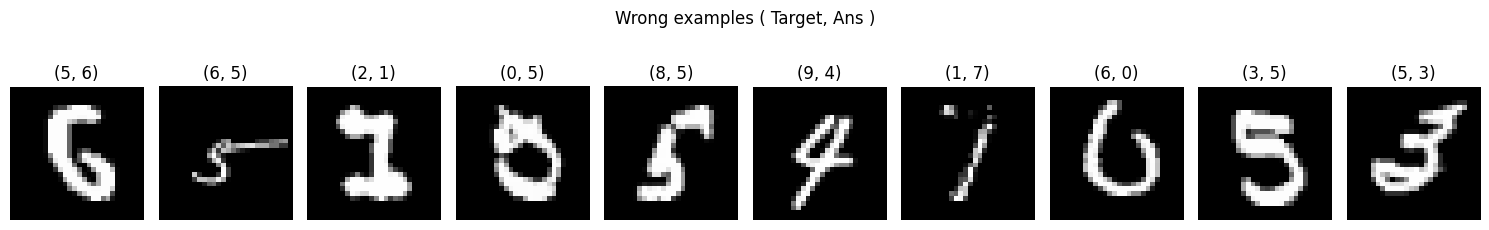

In [6]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

tl_loss, vl_loss = [], []

epochs = 10
for i in range(epochs):

    # train
    model.train()
    tsum = 0.0
    for imgs, lbes in train_loader:
        outimgs = model(imgs)              # forward pass
        tloss = loss_function(outimgs, lbes)# predicted values vs the y_train values
        optimizer.zero_grad()               # clear para gradients
        tloss.backward()                     # backpropagation
        optimizer.step()                    # update parameter

        tsum += tloss.item() * imgs.size(0)

    train_aveloss =tsum / len(train_loader.dataset)
    #print('av loader: ', train_aveloss)
    tl_loss.append(train_aveloss)


    # validate
    model.eval()
    vsum = 0.0
    with torch.no_grad():                       # basically turn of back propogation
        for imgs, lbes in val_loader:
            outimgs = model(imgs)
            vloss = loss_function(outimgs, lbes)
            vsum += vloss.item() * imgs.size(0)
    v_aveloss = vsum / len(val_loader.dataset)
    vl_loss.append(v_aveloss)

    print(f'Epoch {i+1}/{epochs} | train {train_aveloss:.4f} | val {v_aveloss:.4f}')

plt.plot(range(1, epochs+1), tl_loss, label='train')
plt.plot(range(1, epochs+1), vl_loss, label='validate')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('MNIST MLP loss')

plt.legend()
plt.show()


# test
model.eval()

crt_spls, wng_spls = [], []
spls_num = 10

with torch.no_grad():

    for imgs, lbes in test_loader:
        logits = model(imgs)
        pred = logits.argmax(1)

        for i in range(imgs.size(0)):
            unnorm_img = denormalize(imgs[i, 0])
            p, a = int(pred[i]), int(lbes[i])
            if p == a and len(crt_spls) < spls_num:
                crt_spls.append((unnorm_img, p, a))
            elif p != a and len(wng_spls) < spls_num:
                wng_spls.append((unnorm_img, p, a))

        if len(crt_spls) >= spls_num and len(wng_spls) >= spls_num:
            break

def show(samples, title):
    plt.figure(figsize = (1.5*spls_num, 3))
    i = 1
    for img, p, a in samples:
        plt.subplot(1, len(samples), i)
        plt.imshow(img.clamp(0, 1), cmap='gray')
        plt.axis('off')
        plt.title(f'({p}, {a})')
        i += 1

    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

show(crt_spls, 'Correct examples ( Predict , Ans )')
show(wng_spls, 'Wrong examples ( Target, Ans )')


## Attack setup

In [7]:
perturbations = [0,0.01,0.02,0.03,0.04,0.05,0.08,0.1,0.13,0.15,0.18,0.2,0.25,0.3,0.35,0.4,0.5]
eps_list = [0.00, 0.02, 0.05, 0.08, 0.10, 0.15, 0.20, 0.25, 0.30]


In [8]:
def eval_fn(model, pertub_list, attack_fn):
    acc_list = []
    model.eval()
    for i in pertub_list:
        correct = 0
        for imgs, lbes in test_loader:
            nrm_imgs = attack_fn(imgs, lbes, model, i)

            with torch.no_grad():
                out_imgs = model(nrm_imgs)
                pred = out_imgs.argmax(1)
                correct += (pred == lbes).sum().item()

        acc_list.append(correct / len(test_loader.dataset))
        #print(f'perturb={i:.2f}\tAccuracy = {correct} / {len(test_loader.dataset)} = {correct / len(test_loader.dataset):.4f}')
    return acc_list

In [9]:
def constant_fn():
    def attack(imgs, labels, model, const):
        denrm_imgs = denormalize(imgs)
        prtub_imgs = torch.clamp(denrm_imgs + const, 0.0, 1.0)
        return renormalize(prtub_imgs) #return nrm_imgs
    return attack

In [10]:
def noise_fn():
    def attack(imgs, labels, model, pertub):
        denrm_imgs = denormalize(imgs)
        noise = pertub * torch.randn(denrm_imgs.shape)
        noisy_imgs = torch.clamp(denrm_imgs + noise, 0.0, 1.0)
        return renormalize(noisy_imgs)#return nrm_imgs
    return attack

In [11]:
def fgsm_fn(loss_fn):
    def attack(imgs, labels, model, eps):
        denrm_imgs = denormalize(imgs).detach()
        denrm_imgs.requires_grad_(True)

        forwards = model(renormalize(denrm_imgs))
        fg_loss = loss_fn(forwards, labels)

        model.zero_grad(set_to_none=True)
        fg_loss.backward()

        grad_sign = denrm_imgs.grad.detach().sign()
        fg_prtub_imgs = torch.clamp(denrm_imgs + eps * grad_sign, 0.0, 1.0)

        return renormalize(fg_prtub_imgs)#return nrm_imgs

    return attack

## 1b) Attack your MNIST classifier with constant offsets
**Deliverables:**
- Plot your test accuracy as a function of the perturbation magnitude
- Provide some examples where the un-perturbed image was labeled correctly and the perturbed image was labeled incorrectly, despite the perturbed image looking reasonable to a human.

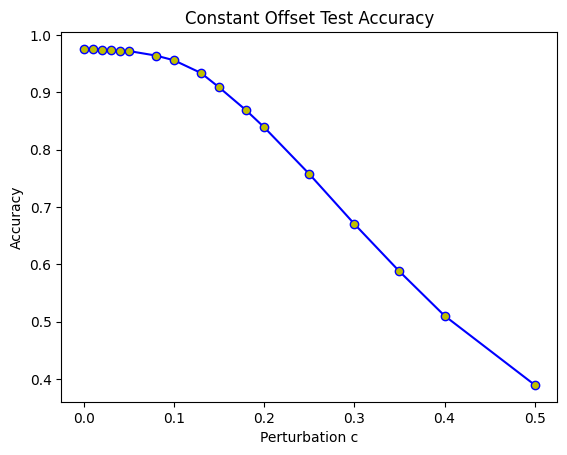

In [12]:
acc_const = eval_fn(model, perturbations, constant_fn())
plot_accuracy(perturbations, acc_const, 'Perturbation c', 'Constant Offset Test Accuracy', 'b')


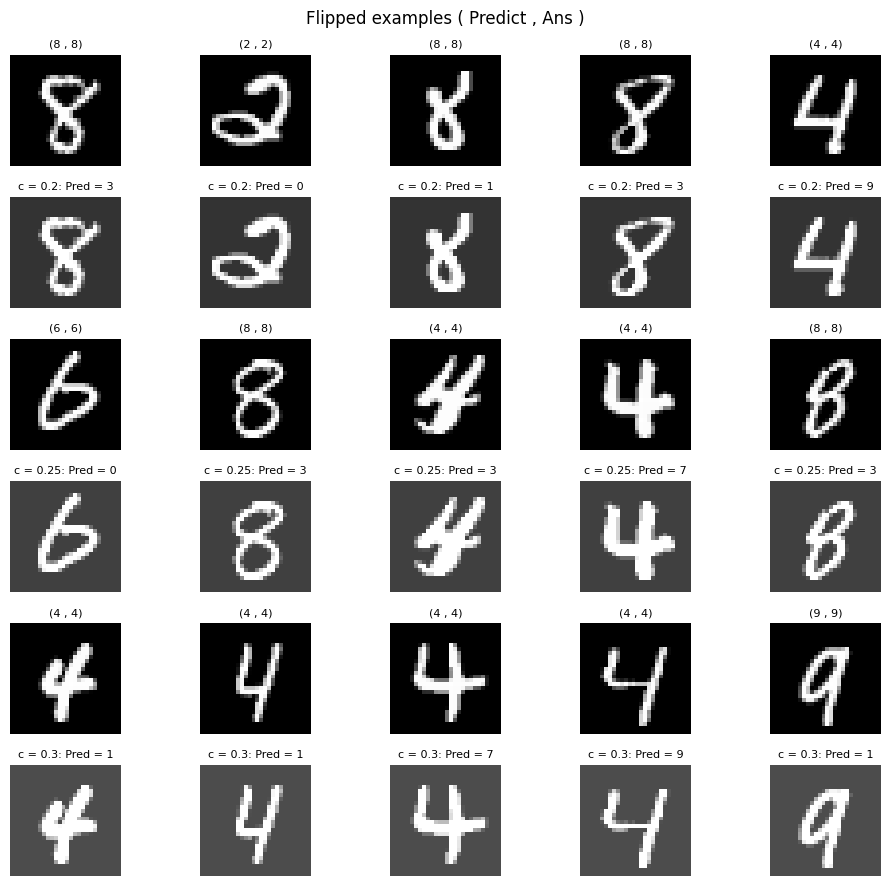

In [13]:
c_show = [0.2, 0.25, 0.3]
cols = 5
c_flip = {} # flips[c]: list of (orig, pert, pred_orig, pred_pert, label)
for c in c_show: c_flip[c] = []

model.eval()
with torch.no_grad():
  for i in c_show:
    for imgs, lbes in test_loader:
        denrm_imgs   = denormalize(imgs)
        prtub_imgs  = torch.clamp(denrm_imgs + i, 0.0, 1.0)
        pred = model(renormalize(denrm_imgs)).argmax(1)
        pred_p = model(renormalize(prtub_imgs)).argmax(1)

        idxs = ((pred == lbes) & (pred_p != lbes)).nonzero(as_tuple=True)[0] # flipped cases

        for idx in idxs[:cols - len(c_flip[i])]:
            c_flip[i].append((denrm_imgs[idx, 0], prtub_imgs[idx, 0], int(pred[idx]), int(pred_p[idx]), int(lbes[idx])))
        if len(c_flip[i]) >= cols: break



plt.figure(figsize = ( 2*cols, 3*len(c_show) ))

j = 0
for c in c_show:
  row = c_flip[c]

  i = 1
  for orig, pert, pd0, pd1, a in row[:cols]:
    # original image
    ax = plt.subplot(2*len(c_show), cols, i + 2*j*cols)
    ax.imshow(orig.clamp(0, 1), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    ax.set_title(f'({pd0} , {a})', fontsize=8)
    # perturbation image
    ax = plt.subplot(2*len(c_show), cols, i + cols + 2*j*cols)
    ax.imshow(pert.clamp(0, 1), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    ax.set_title(f'c = {c}: Pred = {pd1}', fontsize=8)
    i += 1
  j += 1


plt.suptitle('Flipped examples ( Predict , Ans )')
plt.tight_layout()
plt.show()


## 1c) Attack your MNIST classifier with noise
**Deliverables:**
- Plot your test accuracy as a function of the perturbation magnitude
- A couple sentences about any differences observed with constant perturbations vs. noise perturbations

In [ ]:
acc_noise = eval_fn(model, perturbations, noise_fn())
plot_accuracy(perturbations, acc_noise, 'Noise Perturbations', 'Robustness to Gaussian noise', 'b')

In [ ]:
noise_show = [0.1, 0.25, 0.4]
cols = 5

noise_flip = {}
for i in noise_show: noise_flip[i] = []

model.eval()
with torch.no_grad():
  for i in noise_show:
    for imgs, lbes in test_loader:
        denrm_imgs = denormalize(imgs)
        noise = i * torch.randn(denrm_imgs.shape)
        noisy_imgs = torch.clamp(denrm_imgs + noise, 0.0, 1.0)
        pred = model(renormalize(denrm_imgs)).argmax(1)
        pred_p = model(renormalize(noisy_imgs)).argmax(1)

        idxs = ((pred == lbes) & (pred_p != lbes)).nonzero(as_tuple=True)[0]

        for idx in idxs[:cols - len(noise_flip[i])]:
            noise_flip[i].append((denrm_imgs[idx,0], noisy_imgs[idx,0], int(pred[idx]), int(pred_p[idx]), int(lbes[idx])))
        if len(noise_flip[i]) >= cols: break


plt.figure(figsize = ( 2*cols, 3*len(noise_show) ))

j = 0
for noise_i in noise_show:
  row = noise_flip[noise_i]

  i = 1
  for orig, pert, pd0, pd1, a in row[:cols]:

    # original image
    ax = plt.subplot(2*len(noise_show), cols, i + 2*j*cols)
    ax.imshow(orig.clamp(0, 1), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    ax.set_title(f'({pd0} , {a})', fontsize=8)

    # perturbation image
    ax = plt.subplot(2*len(noise_show), cols, i + cols + 2*j*cols)
    ax.imshow(pert.clamp(0, 1), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    ax.set_title(f'noise = {noise_i}: Pred = {pd1}', fontsize=8)
    i += 1
  j += 1

plt.suptitle('Flipped examples under Gaussian noise')
plt.tight_layout()
plt.show()

In [ ]:
#acc_const = eval_fn(model, perturbations, constant_fn())
#acc_noise = eval_fn(model, perturbations, noise_fn())
plt.figure()
plt.plot(perturbations, acc_const, color='orange', label = 'constant') # color = red/blue/green/orange
plt.plot(perturbations, acc_noise, color='green', label = 'noise')
plt.xlabel('Perturbation')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim(0,1)
plt.legend()
plt.show()


### **Comparison**
Constant perturbations change every pixel together, which means changing the brightness of the photo, so it causes a larger accuracy drop. As for Gaussian noise perturbation, it adds some random and scattered pixels in photo, causing the accuracy drops slower.

## 1d) Attack your MNIST classifier with FGSM
**Deliverables:**
- Plot your test accuracy as a function of the perturbation magnitude
- A couple sentences about how this curve compares to the constant perturbations and noise perturbations (hopefully, FGSM should be able to achieve lower test accuracy for the same attack magnitude as those model-agnostic attacks)

In [ ]:
acc_fgsm = eval_fn(model, eps_list, fgsm_fn(loss_function))
plot_accuracy(eps_list, acc_fgsm, 'perturbation epsilon', 'FGSM Test Accuracy', 'b')

In [ ]:
#acc_const = eval_fn(model, perturbations, constant_fn())
#acc_noise = eval_fn(model, perturbations, noise_fn())
acc_fgsm = eval_fn(model, perturbations, fgsm_fn(loss_function))
plt.figure()
plt.plot(perturbations, acc_const, color='orange', label = 'constant') # color = red/blue/green/orange
plt.plot(perturbations, acc_noise, color='green', label = 'noise')
plt.plot(perturbations, acc_fgsm, color='purple', label = 'fgsm')
plt.xlabel('Perturbation')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim(0,1)
plt.legend()
plt.show()



### **Comparison**
As shown above, the FGSM attack is more effective than the other two. With a tiny change (perturbation of 0.1), FGSM can make the model's accuracy drop from 100% to 20%, while the other tow methods still have almost 100%.

The FGSM attack calculating the model's gradient, which is a sensitive and weak part for model, so the FGSM curve drops faster than noise/constant curves

## 1e) Attack your MNIST classifier with Targeted FGSM

# Problem 2: Investigating Decision Boundaries

## 2a) Generate training data

For $x\in R^2$, using the decision rule $f(x) = \begin{cases} 1, &\lvert\lvert x \rvert\rvert_2 \leq 3 \\ 0, & \text{o.w.} \end{cases}$, generate a training, validation, and test set of $[x, f(x)]$ pairs.

**Deliverables:**
- Plot your training set and the true decision boundary

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import math

torch.manual_seed(40)

r = 3.0

x = torch.empty(6000, 2)
x[:, 0].uniform_(-5.0, 5.0)
x[:, 1].uniform_(-5.0, 5.0)

# decision rule
distances = (x**2).sum(dim=1)
y_label = (distances <= (r**2))

train_x, val_x, test_x = x[:3600], x[3600:4200], x[4200:]
train_y, val_y, test_y = y_label[:3600], y_label[3600:4200], y_label[4200:]

plt.figure(figsize=(8, 8))
plt.gca().add_patch(plt.Circle((0, 0), r, color = 'black', fill = False, linewidth = 3, label = f'Boundary r={r}'))
plt.gca().scatter(train_x[~train_y, 0], train_x[~train_y, 1], color = 'orange', alpha = 0.8, s = 5, label='Outside (y=0)')
plt.gca().scatter(train_x[train_y, 0], train_x[train_y, 1], color = 'pink', alpha = 0.8, s = 5, label='Inside (y=1)')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()


## 2b) Train NN classifier

Train a NN classifier on the data you just generated.

**Deliverables**:
- Plot your train & validation loss curves as a function of epoch

In [ ]:
class neuralnetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(2, 64)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(64, 32)
    self.relu = nn.ReLU()
    self.fc3 = nn.Linear(32, 1)

  def forward(self, x):
      x = self.flatten(x)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      x = self.relu(x)
      x = self.fc3(x)
      return x

model = neuralnetwork()
print(model)

In [ ]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

tl_loss, vl_loss = [], []
epochs = 200

for i in range(epochs):

    model.train()
    optimizer.zero_grad()
    t_outputs = model(train_x).squeeze()
    t_loss = loss_function(t_outputs, train_y.float())
    t_loss.backward()
    optimizer.step()
    tl_loss.append(t_loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(val_x).squeeze()
        val_loss = loss_function(val_outputs, val_y.float())
    vl_loss.append(val_loss.item())

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), tl_loss, label='Training Loss', color='blue', linewidth=2)
plt.plot(range(1, epochs + 1), vl_loss, label='Validation Loss', color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

## 2c) Compare decision boundaries

**Deliverables**:
- Plot the true and learned decision boundaries
- A few sentences (with relevant figures to illustrate observations) about any differences and how changes to the model architecture or training procedure can impact decision boundaries (e.g., adding regularization, changing the training data generation method, changing the activation functions).

In [ ]:

gx, gy = np.meshgrid(np.linspace(-5, 5, 300), np.linspace(-5, 5, 300))
grid = np.stack([gx.ravel(), gy.ravel()], axis = 1)
grid_t = torch.from_numpy(grid).float()

# 用模型算機率
model.eval()
with torch.no_grad():
    logits = model(grid_t).squeeze()
    probs = torch.sigmoid(logits).numpy()

# 畫圖
plt.figure(figsize = (8,8))
plt.gca().add_patch(plt.Circle((0, 0), r, color='black', fill=False, linewidth = 3, label = f'True boundary r={r}'))
plt.contour(gx, gy, probs.reshape(gx.shape), levels=[0.5], colors='green', linewidths = 3, linestyles='--', label = 'Learned boundary')

plt.scatter(train_x[~train_y,0], train_x[~train_y,1], color='orange', alpha = 0.8, s=5, label = 'Outside (y=0)')
plt.scatter(train_x[train_y,0], train_x[train_y,1], color='pink', alpha = 0.8, s=5, label = 'Inside (y=1)')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.title('True vs Learned Decision Boundary')
plt.show()